In [1]:
import os

from dotenv import load_dotenv
# use pip install "labelbox[data]"
from labelbox import Client

from koger_detection.labelbox.annotations import download_annotation_projects

In [2]:
# Load local .env file that contains local path "ROOT" and "LABELBOX_API_KEY"
load_dotenv()

research_project = "high-elevation"

project_names = ["salmon-high-altitude-train-1",
                 "salmon-high-altitude-train-3"]
annotation_folder = os.path.join(os.environ.get("ROOT"), "annotations", research_project)

client = Client(api_key=os.environ.get("LABELBOX_API_KEY"))

download_annotation_projects(annotation_folder, client, project_names)

1484it [00:00, 775716.24it/s]


1743it [00:00, 802136.48it/s]


## Merge annotations from multiple projects

In [3]:
from koger_detection.utils.json import combine_jsons

In [4]:
json_names = ["salmon-high-altitude-train-1.json",
              "salmon-high-altitude-train-3.json"]
json_files = [os.path.join(annotation_folder, name) for name in json_names]
out_file = os.path.join(annotation_folder, "combined.json")
combine_jsons(json_files, out_file=out_file)

There are 83 annotated images with 3227 annotations in the JSON files.
83 images added to new .json
3227 annotations added to new .json


## Split annotations into train and val set

In [5]:
from koger_detection.utils.json import create_train_val_split

In [6]:
json_file = os.path.join(annotation_folder, "combined.json")
fraction_val = .25
create_train_val_split(json_file, fraction_val, train_name="train.json", 
                       val_name="val.json")

There are 83 annotated images.
62 training images with 2640 annotations.
21 validation images with 587 annotations.


## Bonus: Visualize annotations

In [7]:
import matplotlib.pyplot as plt

import torch
# Note: also need to install pycocotools
from torchvision import datasets
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import torchvision.transforms.functional as F

In [8]:
example_json = os.path.join(annotation_folder, f"val.json")
image_folder = os.path.join(annotation_folder, "images")

dataset = datasets.CocoDetection(root=image_folder, annFile=example_json)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


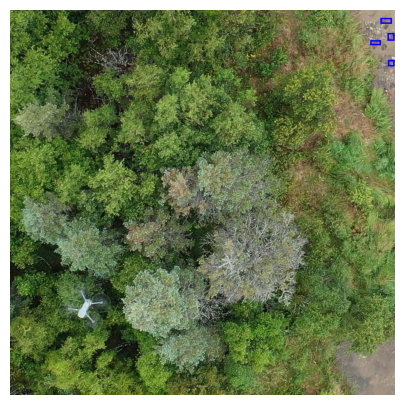

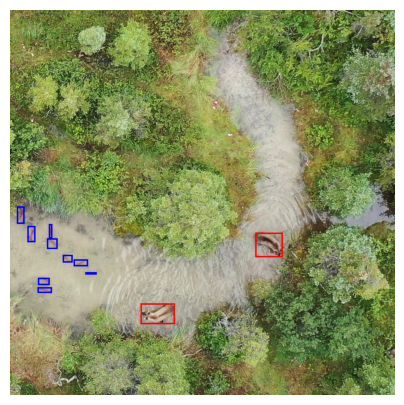

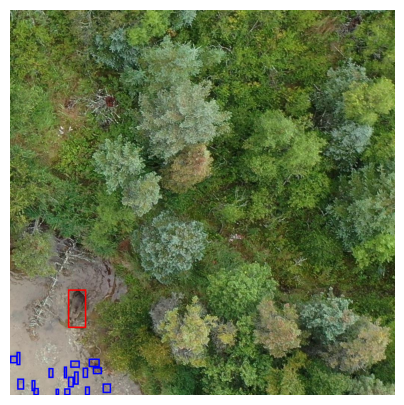

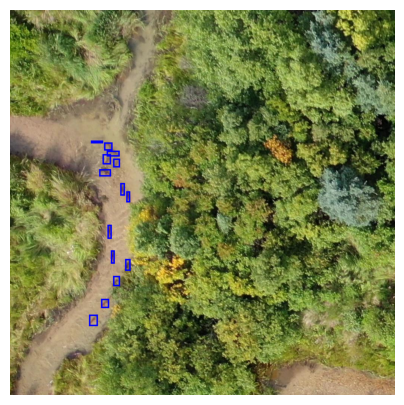

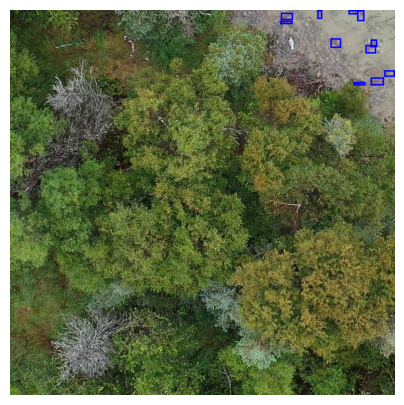

In [28]:
for im_ind in range(0, 5):
    ann = dataset[im_ind]

    boxes = torch.vstack([box_convert(torch.tensor(a['bbox']), "xywh", "xyxy") for a in ann[1]])
    labels = [a['category_id'] for a in ann[1]]
    # If more than 4 classes need to add more colors
    colors = [(230,215,255), (255, 0, 0), (0, 255, 0), (0, 0, 255)]
    box_colors = [colors[l-1] for l in labels]
    image = F.pil_to_tensor(ann[0])
    if len(boxes) > 0:
        image = draw_bounding_boxes((image).type(torch.uint8), 
                                      boxes=boxes, colors=box_colors,
                                      width=4)
    else:
        print("No annotations")
    plt.figure(figsize=(5, 5))
    plt.imshow(F.to_pil_image(image))
    plt.axis('off')  